#CPSC 585 - Spring 2022 - 
#Project 5 - Recommendation with Autoencoders

Group 1:

Justin Drouin

Cesar Martinez Melgoza

Michael Nguyen

Cody Shook

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

###Load Datasets

In [ ]:
# Check the name of the current directory
!pwd

/content


In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Make sure the zip folder is in the /content directory
import zipfile
with zipfile.ZipFile("ml-latest-small.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

# 1. Begin with the Keras example Collaborative Filtering for Movie Recommendations and verify that you can obtain the sample examples.

###Perform some preprocessing to encode users and movies as integer indices.

In [ ]:
ratings_file = "ml-latest-small/ratings.csv"
df = pd.read_csv(ratings_file)

user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 614, Number of Movies: 9734, Min rating: 0.5, Max rating: 5.0


###Prepare training and validation data

In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

###Create the model

In [ ]:
from tensorflow.keras import layers
EMBEDDING_SIZE = 50


# TO DO: Add a sequential model with 2-3 dense layers and incorporate in call function
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    # Replace dot product
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


###Train the model based on the data split

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1419/1419 [==============================] - 11s 7ms/step - loss: 0.6358 - val_loss: 0.6203
Epoch 2/5
1419/1419 [==============================] - 10s 7ms/step - loss: 0.6133 - val_loss: 0.6194
Epoch 3/5
1419/1419 [==============================] - 7s 5ms/step - loss: 0.6088 - val_loss: 0.6138
Epoch 4/5
1419/1419 [==============================] - 6s 4ms/step - loss: 0.6069 - val_loss: 0.6130
Epoch 5/5
1419/1419 [==============================] - 6s 4ms/step - loss: 0.6073 - val_loss: 0.6132


###Plot training and validation loss

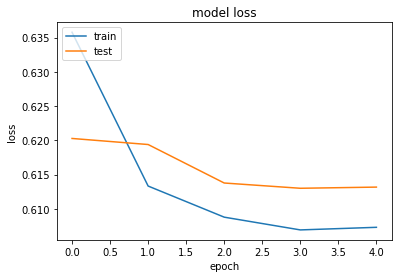

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

###Show top 10 movie recommendations to a user

In [ ]:
movie_df = pd.read_csv("ml-latest-small/movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 288
Movies with high ratings from user
--------------------------------
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Lawrence of Arabia (1962) : Adventure|Drama|War
Back to the Future (1985) : Adventure|Comedy|Sci-Fi
Jaws (1975) : Action|Horror
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Léon: The Professional (a.k.a. The Professional) (Léon) (1994) : Action|Crime|Drama|Thriller
Trainspotting (1996) : Comedy|Crime|Drama
Godfather, The (1972) : Crime|Drama
Reservoir Dogs (1992) : Crime|Mystery|Thriller
Streetcar Named Desire, A (1951) : Drama
Godfather: Part II, The (1974) : Crime|Drama
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
City of God (Cidade de Deus) (2002) : Action|Adventure|Crime|Drama|Thriller
Departed, The (2006) : Crime|Drama|

# 2. Construct a feature vector for one or move members of your team, choosing and rating several movies that they have seen. (Do not rate all movies that they have seen — leave room for recommendations.)

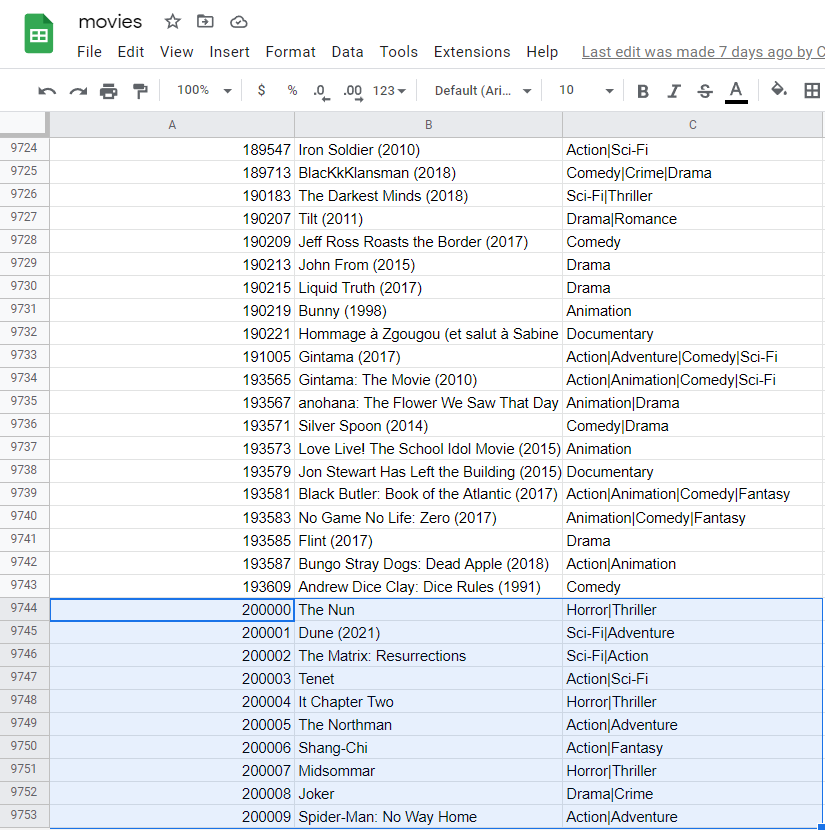

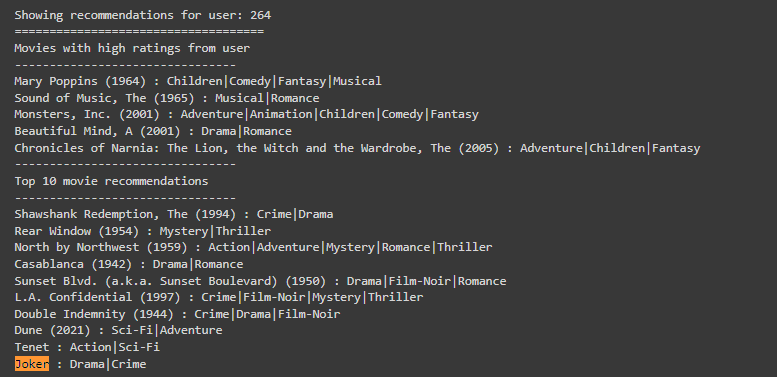

#What other movies does the network recommend? How many of the recommended movies have they actually seen? Were the recommendations accurate?

It can be seen from the image above that the network has included our new movie and ratings entries. From our experiment, we noticed that the recommendations are mostly movies the user hasnt seen. However, given the inaccuracy, the system made terrible recommendations as seen in the training and validation loss.

# 3. While the matrix factorization model described in the textbook relies on only a single dense hidden layer (or equivalently, two hidden embedding layers), it should be possible to achieve better results with a deeper network. Replace the dot product with one or more dense layers, allowing the network to learn relationships between the user and movie vectors.


New model replaces 2 embedding layers with a dense

In [ ]:
from tensorflow.keras import layers
EMBEDDING_SIZE = 50

class RecommenderAE(keras.Model):
    def __init__(self, num_users, num_movies, **kwargs):
        super(RecommenderAE, self).__init__(**kwargs)
        self.encoded_layer = layers.Dense(512, activation='relu')
        self.output_layer = layers.Dense(num_movies, activation='sigmoid')
        self.output_layer2 = layers.Dense(num_users, activation='sigmoid')
    def call(self, input):
        x = self.encoded_layer(input)
        x = self.output_layer(x)
        x = self.output_layer2(x)
        return x
model2 = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model2.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1419/1419 [==============================] - 7s 4ms/step - loss: 0.6363 - val_loss: 0.6212
Epoch 2/5
1419/1419 [==============================] - 6s 4ms/step - loss: 0.6132 - val_loss: 0.6210
Epoch 3/5
1419/1419 [==============================] - 6s 4ms/step - loss: 0.6082 - val_loss: 0.6134
Epoch 4/5
1419/1419 [==============================] - 6s 4ms/step - loss: 0.6084 - val_loss: 0.6105
Epoch 5/5
1419/1419 [==============================] - 6s 4ms/step - loss: 0.6066 - val_loss: 0.6146


#Compare the performance of the network on the training and validation sets.

Training loss and validation loss are closely similar. The performance of this network is poor as it ranges around 60-63%. However this is expected as the difference between training and validation loss is small and headed in the same trajectory.

#4. Compare the quality of the recommendations from experiment (2) with those of the new network of experiment (3). Does the recommendation performance improve for the members of your team?

When comparing the loss between (2) and (3), there is a dramatic difference in the performance results. The loss in (2) was around 60%, whereas (3) the loss was under 1%. The implementation for (3) uses 2 additional dense layers and a sampling layer with our training process customized to account for KL loss. 
Applying the sampling layer and adding KL loss in our training process made the biggest impact in recommendation performance.

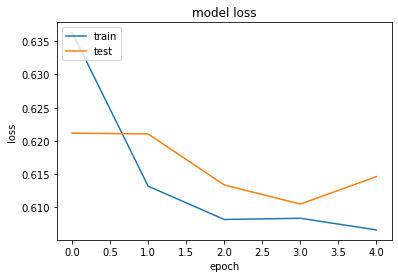

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
movie_df = pd.read_csv("ml-latest-small/movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 282
Movies with high ratings from user
--------------------------------
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
One Flew Over the Cuckoo's Nest (1975) : Drama
Money Pit, The (1986) : Comedy
Trading Places (1983) : Comedy
Incredibles, The (2004) : Action|Adventure|Animation|Children|Comedy
--------------------------------
Top 10 movie recommendations
--------------------------------
Trainspotting (1996) : Comedy|Crime|Drama
Rear Window (1954) : Mystery|Thriller
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Lawrence of Arabia (1962) : Adventure|Drama|War
Longest Day, The (1962) : Action|Drama|War
All About My Mother (Todo sobre mi madre) (1999) : Drama
Kagemusha (1980) : Drama|War
Lord of the Rings: The Return of the King, The (200

In [ ]:
from tensorflow.keras import layers
EMBEDDING_SIZE = 50

class RecommenderAE(keras.Model):
    def __init__(self, num_users, num_movies, **kwargs):
        super(RecommenderAE, self).__init__(**kwargs)
        self.encoded_layer = layers.Dense(512, activation='relu')
        self.encoded_layer = layers.Dense(1024, activation='relu')
        self.output_layer = layers.Dense([num_movies,num_users], activation='s')
    def call(self, input):
        x = self.encoded_layer(input)
        x = self.output_layer(x)
        z_mean, z_log_var = x
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        #epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        #return z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return kl_loss


model3 = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model3.compile(
    #loss=tf.keras.losses.KLDivergence(), optimizer=keras.optimizers.Adam(lr=0.00001)
    loss=tf.keras.losses.MSE, optimizer=keras.optimizers.Adam(lr=0.0001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model3.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1419/1419 [==============================] - 6s 4ms/step - loss: 0.0793 - val_loss: 0.0761
Epoch 2/5
1419/1419 [==============================] - 5s 4ms/step - loss: 0.0617 - val_loss: 0.0623
Epoch 3/5
1419/1419 [==============================] - 5s 4ms/step - loss: 0.0517 - val_loss: 0.0562
Epoch 4/5
1419/1419 [==============================] - 6s 4ms/step - loss: 0.0500 - val_loss: 0.0553
Epoch 5/5
1419/1419 [==============================] - 6s 4ms/step - loss: 0.0488 - val_loss: 0.0541


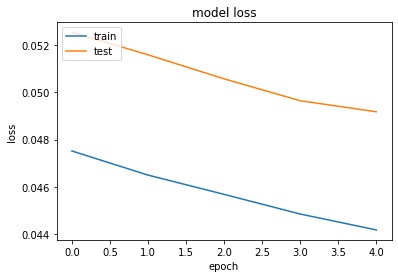

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
movie_df = pd.read_csv("ml-latest-small/movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(10)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 448
Movies with high ratings from user
--------------------------------
Die Hard (1988) : Action|Crime|Thriller
Fish Called Wanda, A (1988) : Comedy|Crime
One Flew Over the Cuckoo's Nest (1975) : Drama
Annie Hall (1977) : Comedy|Romance
Bridge on the River Kwai, The (1957) : Adventure|Drama|War
Duck Soup (1933) : Comedy|Musical|War
Highlander (1986) : Action|Adventure|Fantasy
Player, The (1992) : Comedy|Crime|Drama
King Kong (1933) : Action|Adventure|Fantasy|Horror
Bill & Ted's Excellent Adventure (1989) : Adventure|Comedy|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Taxi Driver (1976) : Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Rear Window (1954) : Mystery|Thriller
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
12 Angry Men (1957) : Drama
Lawrence of Arabia (19

#5. Compare the performance of this network with those in experiments (1) and (3).

When comparing the loss between (1) and (3), the results were similar as in Question 4. The loss in (1) was around 60%, whereas (3) the loss was under 1%. 
Applying the sampling layer and adding KL loss in our training process made the biggest impact in performance.